<a href="https://colab.research.google.com/github/Meichenyou/Fashion_Classification_project/blob/main/Copy_of_Fashion_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [9]:
if torch.cuda.is_available:
  print("GPU is enabled!")
else:
  print("GPU is not enabled.")

GPU is enabled!


In [10]:
# 配置超参数
batch_size = 256
num_workers = 4
lr = 1e-4
epochs = 20

In [11]:
# 设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    # 如果是内置数据集则下方代码需要注释，否则则需要格式的转换
    # transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor()
    ])

In [12]:
# 加载数据集，从网络上直接下载数据集
from torchvision import datasets

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.6MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 229kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.28MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.1MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [13]:
# 在训练和测试时需要加载数据
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([256, 1, 28, 28]) torch.Size([256])


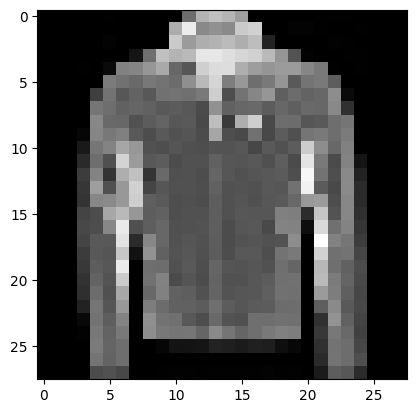

In [14]:
# 做一些数据可视化的操作以验证读入的数据是否准确
import matplotlib.pyplot as plt

image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

In [23]:
# 搭建一个模型的架构

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 32, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Dropout(0.3),
        nn.Conv2d(32, 64, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Dropout(0.3)
    )
    self.fc = nn.Sequential(
        nn.Linear(64*4*4, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1, 64*4*4)
    x = self.fc(x)
    return x

model = Net()

In [16]:
# 设定损失函数
criterion = nn.CrossEntropyLoss()

In [17]:
# 设定优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# 训练和测试
def train(epoch):
  model.train()
  train_loss = 0
  for data, label in train_loader:
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)
  train_loss = train_loss/len(train_loader.dataset)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [19]:
def val(epoch):
  model.eval()
  val_loss = 0
  gt_labels = []
  pred_labels = []
  with torch.no_grad():
    for data, label in test_loader:
      output = model(data)
      preds = torch.argmax(output,1)
      gt_labels.append(label.cpu().data.numpy())
      pred_labels.append(preds.cpu().data.numpy())
      loss = criterion(output, label)
      val_loss += loss.item()*data.size(0)
  val_loss = val_loss/len(test_loader.dataset)
  gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
  acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
  print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [24]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 1 	Training Loss: 2.301884
Epoch: 1 	Validation Loss: 2.304033, Accuracy: 0.082200
Epoch: 2 	Training Loss: 2.301988
Epoch: 2 	Validation Loss: 2.304033, Accuracy: 0.082200
Epoch: 3 	Training Loss: 2.301994
Epoch: 3 	Validation Loss: 2.304033, Accuracy: 0.082200
Epoch: 4 	Training Loss: 2.302040
Epoch: 4 	Validation Loss: 2.304033, Accuracy: 0.082200
Epoch: 5 	Training Loss: 2.301731
Epoch: 5 	Validation Loss: 2.304033, Accuracy: 0.082200
Epoch: 6 	Training Loss: 2.301966
Epoch: 6 	Validation Loss: 2.304033, Accuracy: 0.082200
Epoch: 7 	Training Loss: 2.301799
Epoch: 7 	Validation Loss: 2.304033, Accuracy: 0.082200
Epoch: 8 	Training Loss: 2.301896
Epoch: 8 	Validation Loss: 2.304033, Accuracy: 0.082200
Epoch: 9 	Training Loss: 2.301866
Epoch: 9 	Validation Loss: 2.304033, Accuracy: 0.082200


KeyboardInterrupt: 